In [6]:
model_name = 'CERBERUS_ANYMAL_C_SENSOR_CONFIG_2'
model_name = 'Panda with Ignition position controller model'
model_name = 'ur5_rg2'
model_name = 'NAO with Ignition position controller'
model_name = 'mpl_right_arm'

In [7]:
gazebo_plugin_location = '/home/marcogg/ModelPhotoShoot/build/'
temp_dir = '/home/marcogg/repro/drake_stuff/mbp_robot_arm_joint_limit_stuff/temporal'
model_dir = '/home/marcogg/repro/drake_stuff/mbp_robot_arm_joint_limit_stuff/repos/' + model_name
model_file = 'model.sdf'

In [8]:
!mkdir -p $temp_dir/visual/pics/default_pose/

In [9]:
%cd "$model_dir"

/home/marcogg/repro/drake_stuff/mbp_robot_arm_joint_limit_stuff/repos/MPL right arm


In [10]:
!GAZEBO_PLUGIN_PATH=$gazebo_plugin_location gzserver -s libmodelphotoshoot.so worlds/blank.world --propshop-save $temp_dir/visual/pics/default_pose/ --propshop-model "$model_dir/$model_file" --data-file $temp_dir/visual/pics/default_pose/poses.txt

/home/marcogg/repro/drake_stuff/mbp_robot_arm_joint_limit_stuff/repos/mpl_right_arm/model.sdf
end load
start init
end init
on world
end on world
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
update
waiting to load
upda

In [6]:
!mkdir -p $temp_dir/visual/pics/random_pose/

In [7]:
!GAZEBO_PLUGIN_PATH=$gazebo_plugin_location gzserver -s libmodelphotoshoot.so worlds/blank.world --propshop-save $temp_dir/visual/pics/random_pose/ --propshop-model "$model_dir/$model_file" --data-file $temp_dir/visual/pics/random_pose/poses.txt  --random-joints

Warning [Model.cc:212] Non-unique names detected in XML children of model with name[naoH25V40].


In [11]:
import numpy as np
import sys
from PIL import Image

from pydrake.all import (
    FindResourceOrThrow,
    Parser,
    AddMultibodyPlantSceneGraph,
    ConnectMeshcatVisualizer,
    DiagramBuilder,
    JacobianWrtVariable,
    Simulator,
)
from pydrake.geometry.render import (
    ClippingRange,
    DepthRange,
    ColorRenderCamera,
    RenderCameraCore,
    DepthRenderCamera,
    RenderLabel,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
)
from pydrake.geometry import (
    DrakeVisualizer,
    HalfSpace,
    FrameId,
)
from pydrake.systems.sensors import (
    CameraInfo,
    RgbdSensor,
)
from pydrake.math import RigidTransform, RollPitchYaw
import pydrake.multibody as mb
import multibody_extras as me
import matplotlib.pyplot as plt

In [12]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)
  
def make_parser(plant):
    parser = Parser(plant)
    parser.package_map().PopulateFromFolder("/home/marcogg/repro/drake_stuff/mbp_robot_arm_joint_limit_stuff/repos/")
    return parser

def create_camera(builder, world_id, X_WB, color_camera, depth_camera, scene_graph):
    sensor = RgbdSensor(
        world_id, X_PB=X_WB,
        color_camera=color_camera,
        depth_camera=depth_camera)
    builder.AddSystem(sensor)
    builder.Connect(
        scene_graph.get_query_output_port(),
        sensor.query_object_input_port())
    return sensor
  
def generate_images_and_IoT(simulator, sensor, temp_directory, poses_dir, num_image):
  
    context = simulator.get_context()
    sensor_context = sensor.GetMyMutableContextFromRoot(context)
    
    color = sensor.color_image_output_port().Eval(sensor_context).data
    image = Image.frombytes('RGBA', (960,540), color)
    
    image.save( temp_directory + '/pics/' + poses_dir + '/' + str(num_image) + '_drake.png')
    
    with Image.open(temp_directory + '/pics/' + poses_dir + '/' + str(num_image) + '.png') as im1:
      px1 = im1.load()
      
    with image as im2:
      px2 = im2.load()
    
    union_count = 0
    intersection = 0
    for i in range(960):
        for j in range(540):
            if px1[i,j] != (204, 229,255) or  px2[i,j] != (204, 229, 255,255):
                union_count += 1
                if px1[i,j] != (204, 229,255) and  px2[i,j] != (204, 229, 255,255):
                    intersection +=1
    print(intersection/union_count)
    return im1, im2

In [13]:
pose_directory = 'default_pose'
temp_directory = temp_dir + '/visual/'

In [16]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

parser = Parser(plant)
model = make_parser(plant).AddModelFromFile(model_file)

model_bodies = me.get_bodies(plant, {model})

frame_W = plant.world_frame()
frame_B = model_bodies[0].body_frame()

if (len(plant.GetBodiesWeldedTo(plant.world_body())) <2):
  plant.WeldFrames(frame_W, frame_B)

#Creating cameras:
renderer_name = 'renderer'
scene_graph.AddRenderer(
  renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams()))

#camera_info = CameraInfo(width=960, height=540, fov_y=0.62803)
camera_info = CameraInfo(width=960, height=540, focal_x=831.382036787, focal_y=831.382036787, center_x=480, center_y=270)

# N.B. These properties are chosen arbitrarily.
color_camera = ColorRenderCamera(
    RenderCameraCore(
        renderer_name,
        camera_info,
        ClippingRange(0.01, 10.0),
        RigidTransform()))

depth_camera = DepthRenderCamera (
    RenderCameraCore(
        renderer_name,
        camera_info,
        ClippingRange(0.01, 10.0),
        RigidTransform()),
        DepthRange(0.01, 10.0))

world_id = plant.GetBodyFrameIdOrThrow(plant.world_body().index())

random_poses = {}
# Read camera translation calculated and applied on gazebo
# we read the random positions file as it contains everything:
trans_x = 0
trans_y = 0
trans_z = 0
with open (temp_directory + '/pics/' + pose_directory + '/poses.txt', 'r') as datafile:
    for line in datafile:
        if line.startswith("Translation:"):
          line_split = line.split(' ')
          # we make the value negative since gazebo moved the robot 
          # and in drake we move the camera
          trans_x = -float(line_split[1])
          trans_y = -float(line_split[2])
          trans_z = -float(line_split[3])
        else:
          line_split = line.split(' ')
          if line_split[1] == 'nan':
            random_poses[line_split[0]] = 0
          else:
            random_poses[line_split[0]] = float(line_split[1])

print(trans_x, trans_y, trans_z)

#Creating perspective cam
X_WB = xyz_rpy_deg([1.6 + trans_x, -1.6 + trans_y, 1.2 + trans_z], [-120, 0, 45])
sensor_perspective = create_camera(builder, world_id, X_WB, color_camera, depth_camera, scene_graph)

#Creating top cam
X_WB = xyz_rpy_deg([0 + trans_x, 0 + trans_y, 2.2 + trans_z], [-180, 0, -90])
sensor_top = create_camera(builder, world_id, X_WB, color_camera, depth_camera, scene_graph)

#Creating front cam
X_WB = xyz_rpy_deg([2.2 + trans_x, 0 + trans_y, 0 + trans_z], [-90, 0, 90])
sensor_front = create_camera(builder, world_id, X_WB, color_camera, depth_camera, scene_graph)

#Creating side cam
X_WB = xyz_rpy_deg([0 + trans_x, 2.2 + trans_y, 0 + trans_z], [-90, 0, 180])
sensor_side = create_camera(builder, world_id, X_WB, color_camera, depth_camera, scene_graph)

#Creating back cam
X_WB = xyz_rpy_deg([-2.2 + trans_x, 0 + trans_y, 0 + trans_z], [-90, 0, -90])
sensor_back = create_camera(builder, world_id, X_WB, color_camera, depth_camera, scene_graph)

DrakeVisualizer.AddToBuilder(builder, scene_graph)

plant.gravity_field().set_gravity_vector(np.array([0,0,0], dtype = np.float64))

meshcat_vis = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url="new", open_browser=False)

plant.Finalize()
diagram = builder.Build()

simulator = Simulator(diagram)
simulator.Initialize()

dofs = plant.num_actuated_dofs();
if (dofs != plant.num_positions()):
    raise ValueError('Error on converted model: Num positions is not equal to num actuated dofs.')

if (pose_directory == 'random_pose'):
    joint_positions = [0] * dofs
    for joint_name, pose in random_poses.items():
        joint = plant.GetJointByName(joint_name)
        joint_positions[joint.position_start()] = pose

    sim_plant_context = plant.GetMyContextFromRoot(simulator.get_mutable_context())
    plant.get_actuation_input_port(model).FixValue(sim_plant_context, np.zeros((dofs,1)))
    plant.SetPositions(sim_plant_context, model, joint_positions)

    simulator.AdvanceTo(1)

0 0 0
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.


In [17]:
im1, im2 = generate_images_and_IoT(simulator, sensor_perspective, temp_directory, pose_directory, 1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/marcogg/repro/drake_stuff/mbp_robot_arm_joint_limit_stuff/temporal/visual//pics/default_pose/1.png'

In [18]:
im1

NameError: name 'im1' is not defined

In [19]:
im2

NameError: name 'im2' is not defined

In [15]:
im1, im2 = generate_images_and_IoT(simulator, sensor_top, temp_directory, pose_directory, 2)

0.3243637040022321


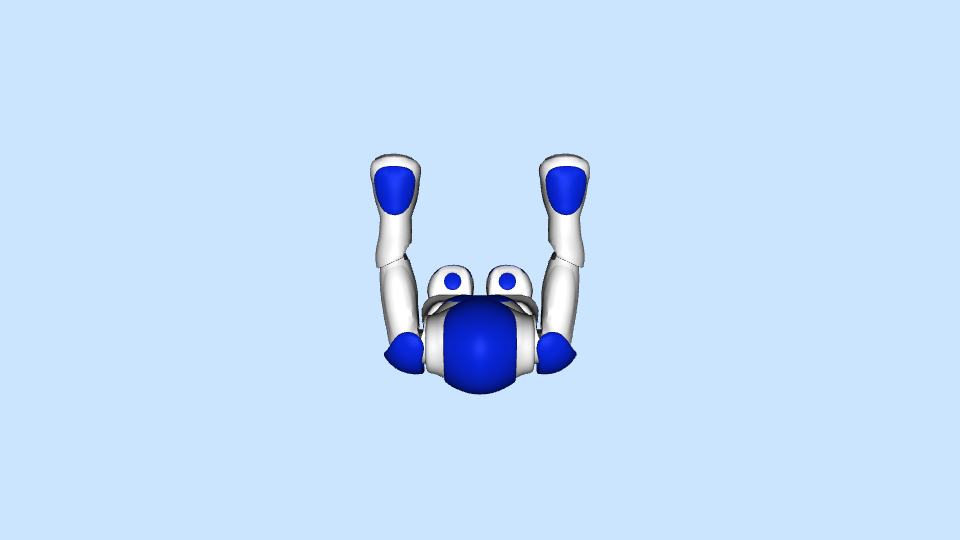

In [16]:
im1

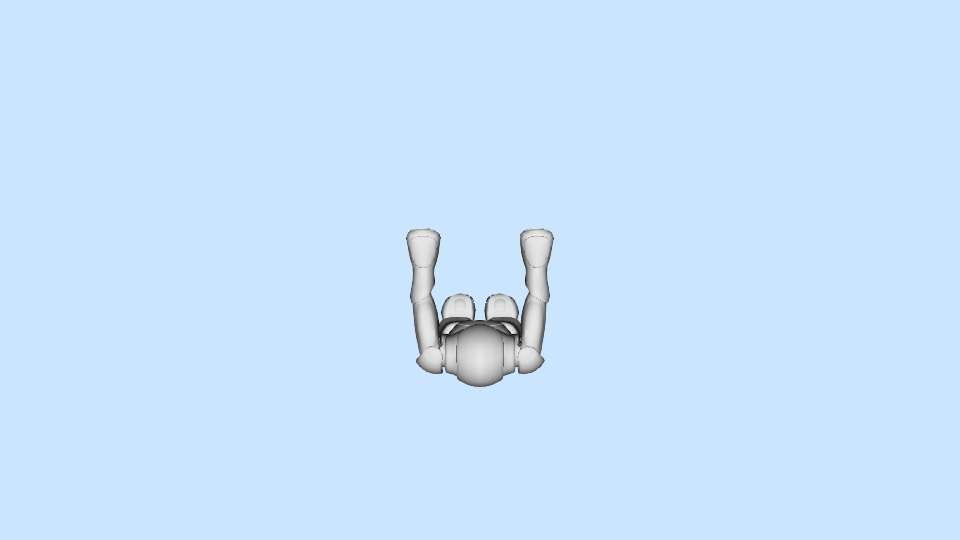

In [17]:
im2

In [18]:
im1, im2 = generate_images_and_IoT(simulator, sensor_front, temp_directory, pose_directory, 3)

0.16019912016670526


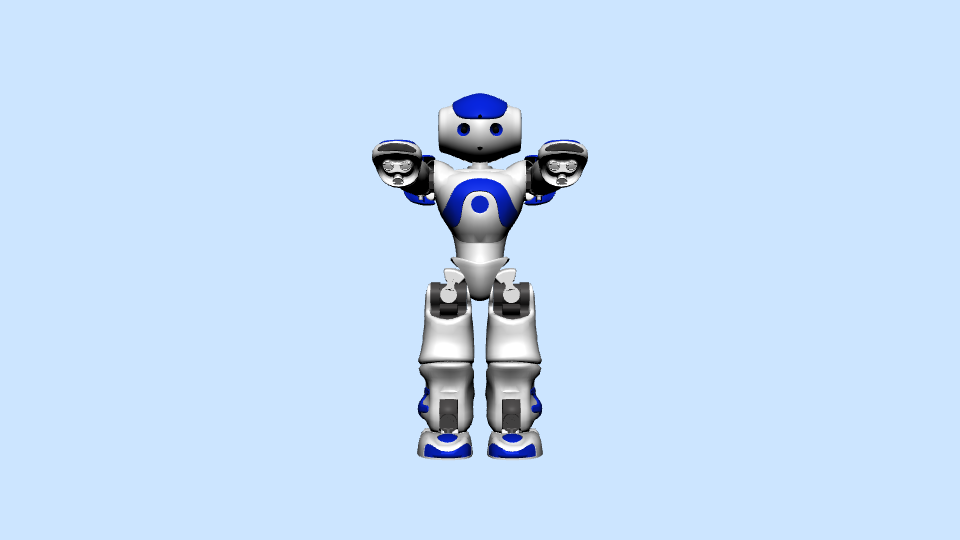

In [19]:
im1

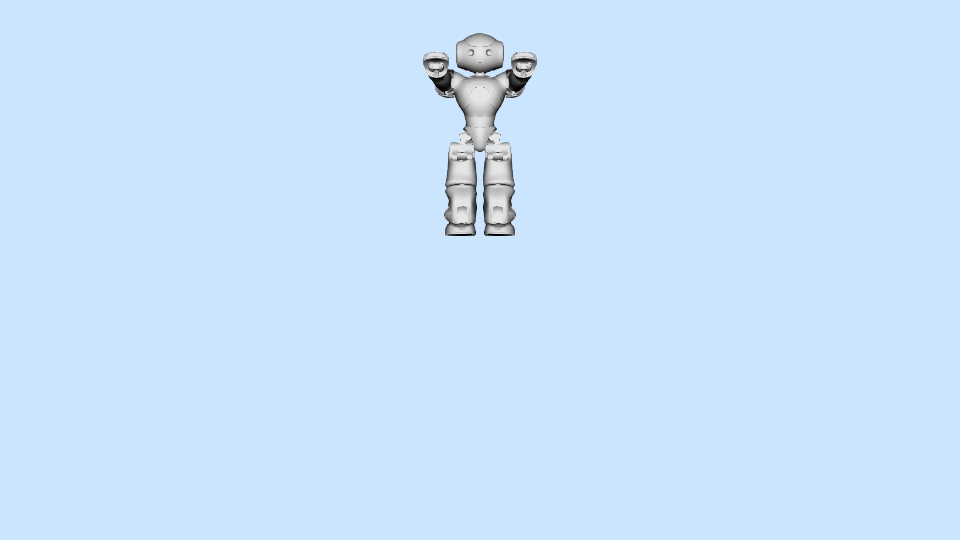

In [20]:
im2

In [21]:
im1, im2 = generate_images_and_IoT(simulator, sensor_side, temp_directory, pose_directory, 4)

0.1464219318687649


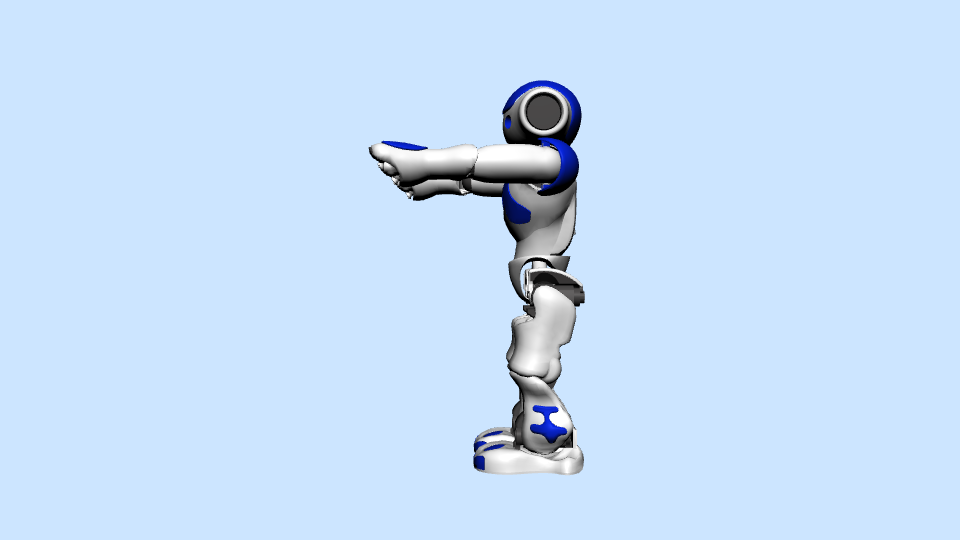

In [22]:
im1

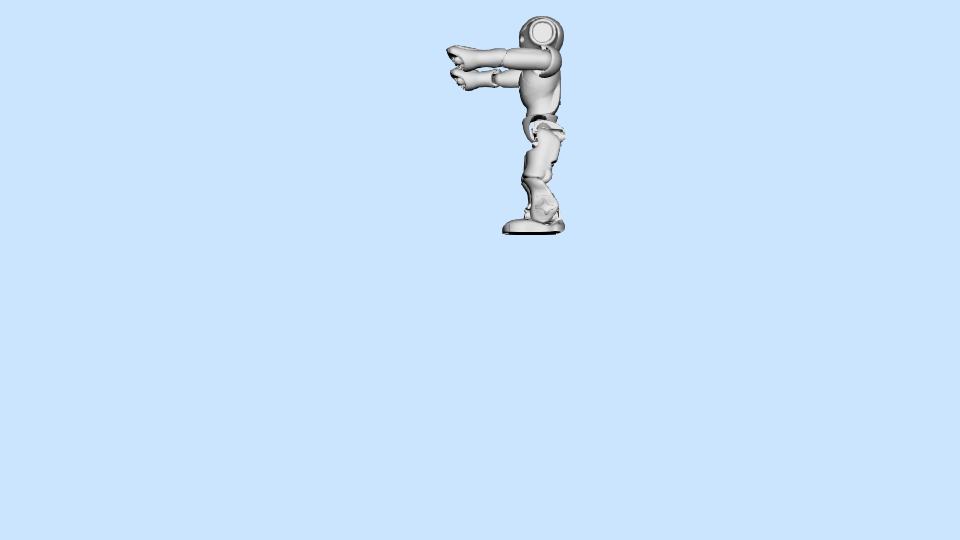

In [23]:
im2

In [24]:
im1, im2 = generate_images_and_IoT(simulator, sensor_back, temp_directory, pose_directory, 5)

0.18050363398295918


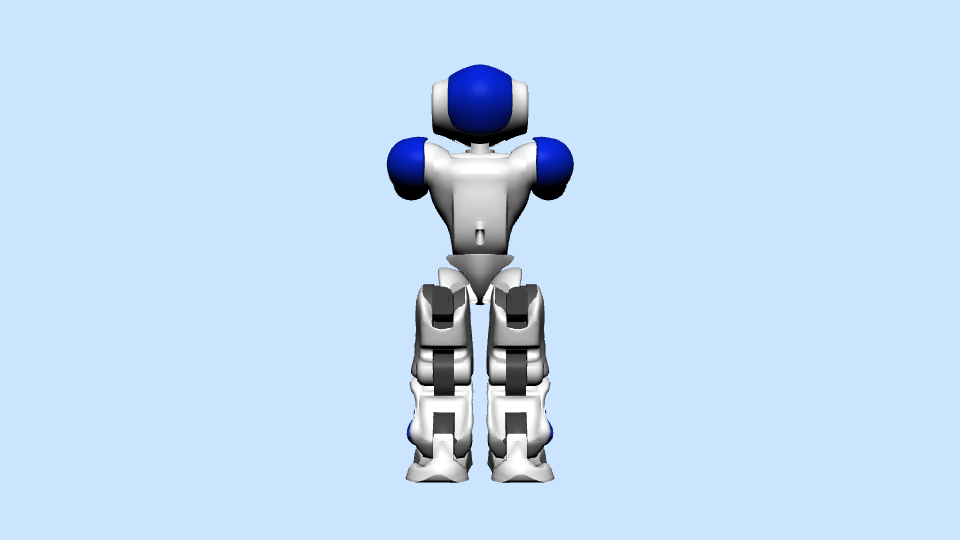

In [25]:
im1

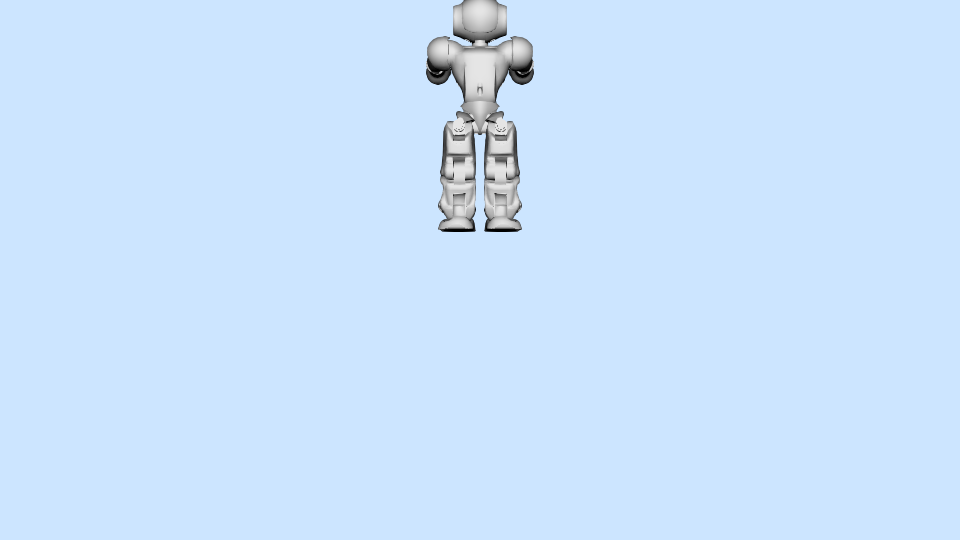

In [26]:
im2

In [27]:
camera_info.intrinsic_matrix()

array([[831.38203679,   0.        , 480.        ],
       [  0.        , 831.38203679, 270.        ],
       [  0.        ,   0.        ,   1.        ]])